Christian H. Bye, Feb 2026.

Spatial filtering with EIGSEP. This is the ideal foreground separation case with no horizon.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

%matplotlib widget

## Load data and define model components

### Beam

In [2]:
b = np.load("/home/christian/Documents/research/eigsep/eigsep_sims/eigsep_bowtie_v000.npz")
freqs = b["freqs"][:-1] / 1e6
nfreq = len(freqs)
beam = b["bm"][:-1]
nside = b["nside"]
npix = hp.nside2npix(nside)

beam /= np.sum(beam*4*np.pi/npix, axis=1, keepdims=True)

lmax = 2*nside
beam_alm = np.array([hp.map2alm(bm, lmax=lmax, use_pixel_weights=True) for bm in beam])
Nalm = hp.Alm.getsize(lmax)

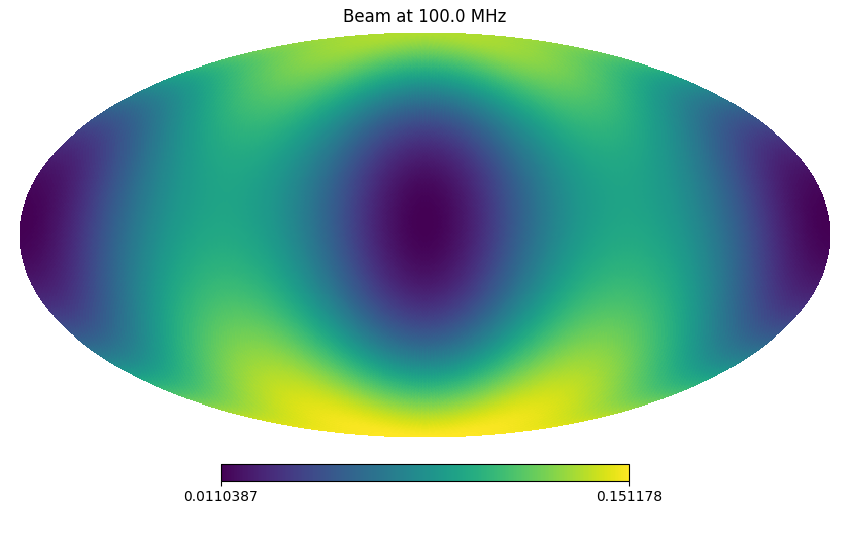

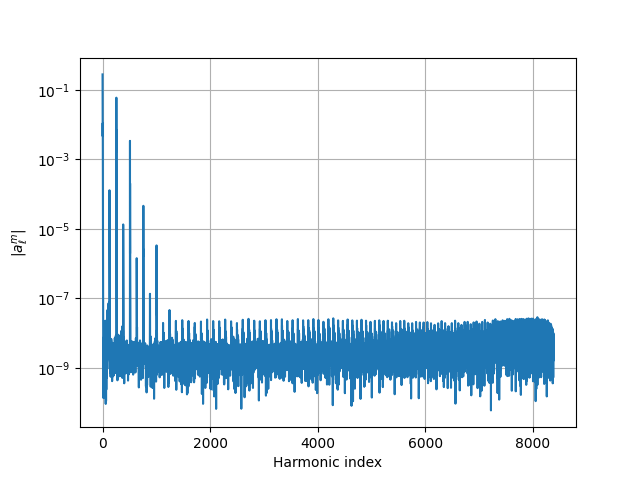

In [3]:
ix = 50

hp.mollview(beam[ix], title=f"Beam at {freqs[ix]} MHz")
plt.show()

plt.figure()
plt.plot(np.abs(beam_alm[ix]))
plt.xlabel("Harmonic index")
plt.ylabel("$|a_\\ell^m|$")
plt.grid()
plt.yscale("log")
plt.show()

In [4]:
def reduce_lmax(alm, old_lmax, new_lmax):
    if new_lmax > old_lmax:
        raise ValueError
    elif new_lmax == old_lmax:
        return alm
    
    ells, emms = hp.Alm.getlm(new_lmax)
    ix = hp.Alm.getidx(old_lmax, ells, emms)
    new_alm = alm[..., ix]
    return new_alm

In [5]:
# averaging is only going to reduce the lmax further, might as well reduce the bandlimit already
new_lmax = np.where(np.abs(beam_alm[:, :lmax+1]) > 1e-6, np.arange(lmax + 1), -1).max()
print(new_lmax, lmax)

beam_alm = reduce_lmax(beam_alm, lmax, new_lmax)
lmax = new_lmax
Nalm = hp.Alm.getsize(lmax)

15 128


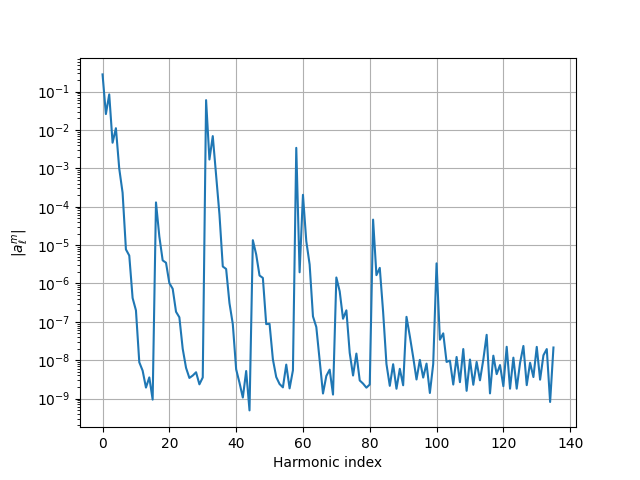

In [6]:
plt.figure()
plt.plot(np.abs(beam_alm[ix]))
plt.xlabel("Harmonic index")
plt.ylabel("$|a_\\ell^m|$")
plt.grid()
plt.yscale("log")
plt.show()

## Define beam rotations

We assume we have measurements with the beam at 10 deg steps.

In [8]:
alt = np.linspace(0, 2*np.pi, num=36, endpoint=False)
az = np.linspace(0, 2*np.pi, num=36, endpoint=False)
print(np.rad2deg(alt))

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350.]


In [9]:
def get_rot(alt, az):
    """
    Helper function to get healpy Rotator object for rotation of `alt' around X-axis then `az' around new Z-axis.
    Eulertype = "X" does: 1. rotate around orignal Z, 2. rotate aournd interim X, 3. rotate around final Z.
    Also, healpy flips the sign for the middle rotation internally for some reason, and returns the transpose matrix.
    
    """
    eul = (0, -alt, az)
    r = hp.Rotator(rot=eul, eulertype="X", deg=False, inv=False)
    return r

In [10]:
beam_rot_alm = np.empty((len(alt), len(az), nfreq, Nalm), dtype=complex)

for i in range(len(alt)):
    for j in range(len(az)):
        rot = get_rot(alt[i], az[j])
        for k in range(nfreq):
            beam_rot_alm[i, j, k] = rot.rotate_alm(beam_alm[k], lmax=lmax)

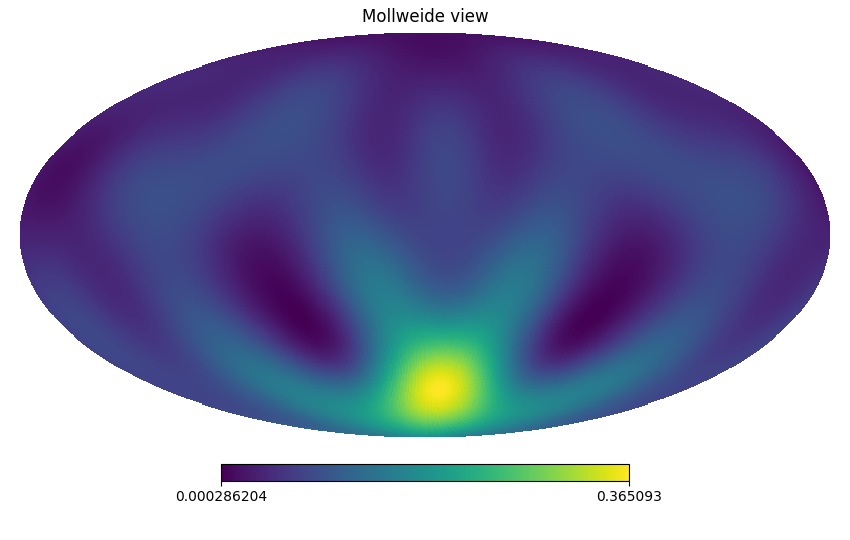

In [11]:
hp.mollview(hp.alm2map(beam_rot_alm[15, 10, -1], nside=nside))

## Optimize

Since 21cm is a monopole, we aim to combine beam rotations to get something close isotropic for the synthesized beam.

In [12]:
# preaverage over az
azwgts = np.ones(len(az))
beam_rot_alt = np.sum(beam_rot_alm * azwgts[None, :, None, None], axis=1) / np.sum(azwgts)
print(beam_rot_alt.shape)

(36, 201, 136)


### QR decomposition of the matrix

Denote the synthesized beam by $\mathbf{s}$ (shape Nalm) and the beam at each rotation by $\mathbf{B}$ shape (Nalm, Nrot). The rotation weights are $\mathbf{w}$ with length (Nrot). Our goal is to obtain $\mathbf{s} = (1, 0, \dots, 0)$. If we delete the monopole row, we want $\mathbf{s} = \mathbf{0}$, ie. we're looking for $\mathbf{w}$ in the kernel of $\mathbf{B}$.

In [32]:
import scipy.linalg
import scipy.optimize

In [14]:
# change view of beam_rot alt to useful matrix view
beam_rot_alt_mat = np.moveaxis(beam_rot_alt, 0, 2)
print(beam_rot_alt_mat.shape)

(201, 136, 36)


In [15]:
# delete monopole row and stack
beam_rot_alt_stack = np.concatenate(beam_rot_alt_mat[:, 1:], axis=0)
q, r, p = scipy.linalg.qr(beam_rot_alt_stack.T, pivoting=True)  # do QR on transpose
print(q.shape, r.shape, p.shape, beam_rot_alt_stack.shape)

(36, 36) (36, 27135) (27135,) (27135, 36)


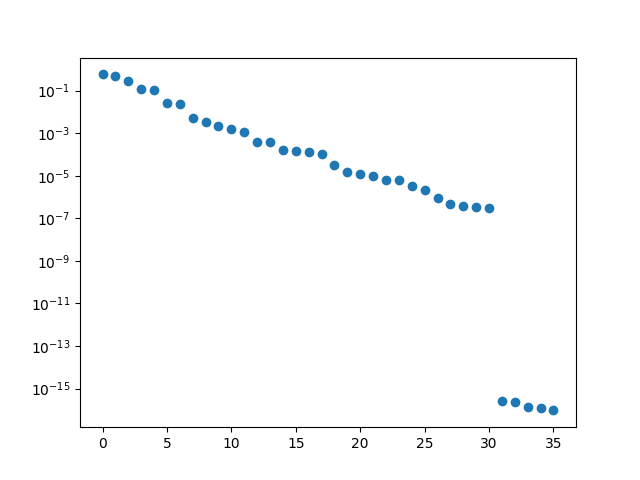

In [16]:
plt.figure()
plt.plot(np.diag(np.abs(r)), ls="none", marker="o")
plt.yscale("log")
plt.show()

In [17]:
# kernel is linear combinations of last five vectors
kerdim = 5
ker = q[:, -kerdim:] 
# confirm this is the kernel:
print(np.abs(beam_rot_alt_mat[:, 1:] @ ker).max())

# check if this is still the kernel if we add back the monopole row
print(np.abs(beam_rot_alt_mat @ ker).max())

2.2723597255177743e-16
2.2723597255177743e-16


Didn't work because every weight vector in the kernel also removes the monopole.

In [190]:
def nnls(beam_mat):
    """
    Non-Negative Least Squares

    Parameters
    ----------
    beam_mat : ndarray
        Shape is (Nfreq, Nalm, Nrot)
        Looking for weights of length (Nrot) to average the last axis.

    Returns
    -------
    wlsq : ndarray
        Shape is (Nrot)
        Minimizes ||beam_mat @ wlsq - monopole|| averaged over frequency and harmonic index,
        subject to wlsq >= 0 and ||wlsq|| = 1.
    
    """
    # do least squared instead, don't delete first row!
    monopole = np.zeros(beam_mat.shape[:-1], dtype=complex)  # Nfreq, Nalm
    monopole[:, 0] = 1/np.sqrt(4 * np.pi)
    
    # collapse Nfreq/Nalm
    beam_stack = np.concatenate(beam_mat, axis=0)
    monopole = np.concatenate(monopole, axis=0)
    monopole = monopole[:, None]
    
    print(f"{monopole.shape=}")
    print(f"{beam_stack.shape=}")

    # need to split real/imag, and enforce weights >= 0
    beam_reim = np.vstack([np.real(beam_stack), np.imag(beam_stack)])
    monopole_reim = np.vstack([np.real(monopole), np.imag(monopole)])
    
    print(f"{monopole_reim.shape=}")
    print(f"{beam_reim.shape=}")
    # expected shape
    print(f"expected shape, {(beam_reim.shape[1], monopole_reim.shape[1])}")

    wlsq, res_sq = scipy.optimize.nnls(beam_reim, monopole_reim)
    wlsq /= np.sum(wlsq)

    print(wlsq.shape)

    # squeeze
    wlsq = np.squeeze(wlsq)
    return wlsq

In [193]:
wlsq = nnls(beam_rot_alt_mat)

monopole.shape=(27336, 1)
beam_stack.shape=(27336, 36)
monopole_reim.shape=(54672, 1)
beam_reim.shape=(54672, 36)
expected shape, (36, 1)
(36,)


### JAX

In [52]:
import jax
import jax.numpy as jnp
import optax

In [53]:
jb = jnp.asarray(beam_rot_alt)

In [54]:
def get_sbeam(altwgts):
    return jnp.sum(jb * altwgts[:, None, None], axis=0) / jnp.sum(jnp.abs(altwgts))

def compute_res(altwgts):
    sbeam = get_sbeam(altwgts)
    monobeam = jnp.zeros_like(sbeam)
    monobeam = monobeam.at[:, 0].set(1/jnp.sqrt(4*jnp.pi))
    res = sbeam - monobeam
    return res

def loss_fn(altwgts):
    res = compute_res(altwgts)
    return jnp.mean(jnp.abs(res)**2)

In [74]:
opt = optax.adam(learning_rate=1e-2)
altwgts = jnp.zeros(len(alt))
altwgts = altwgts.at[0].set(1.)
opt_state = opt.init(altwgts)


wgts = {
    "zenith_sweep": altwgts,
    "uniform": jnp.ones(len(alt)),
    "sin": jnp.abs(jnp.sin(alt)),
    "lsq": wlsq
}

losses = {k: loss_fn(v) for k, v in wgts.items()}

In [75]:
# compare to guass legendre
gla0 = jnp.pi/2
gla1 = jnp.arccos(jnp.sqrt(3/5))
gla2 = jnp.arccos(-jnp.sqrt(3/5))

glangs = [gla0, gla1, gla2]

# add symmetry
glangs.extend([g+jnp.pi for g in glangs])
print(len(glangs))

glix = [jnp.argmin(jnp.abs(alt-gla)) for gla in glangs]

gl_weights = jnp.zeros(len(alt))
gl_weights = gl_weights.at[glix[0]].set(8/9)
gl_weights = gl_weights.at[glix[1]].set(5/9)
gl_weights = gl_weights.at[glix[2]].set(5/9)

gl_weights = gl_weights.at[glix[3]].set(8/9)
gl_weights = gl_weights.at[glix[4]].set(5/9)
gl_weights = gl_weights.at[glix[5]].set(5/9)


wgts["gl"] = gl_weights
losses["gl"] = loss_fn(gl_weights)

6


In [76]:
@jax.jit
def step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss_value

In [77]:
epochs = 1000
loss_list = jnp.empty(epochs)
for i in range(epochs):
    altwgts, opt_state, lv = step(altwgts, opt_state)
    altwgts = altwgts.clip(min=0)
    loss_list = loss_list.at[i].set(lv)

wgts["best_fit"] = altwgts
losses["best_fit"] = loss_list[-1]

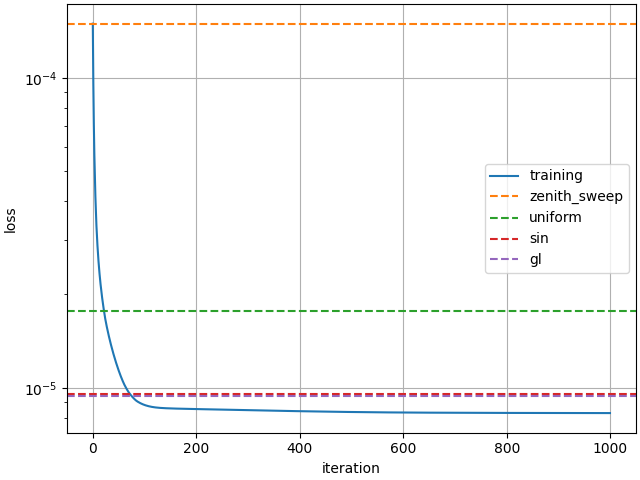

In [86]:
plt.figure(constrained_layout=True)
plt.plot(loss_list, label="training")
ci = 1
for k, v in losses.items():
    if k in ("best_fit", "lsq"):
        continue
    plt.axhline(v, ls="--", label=k, c=f"C{ci}")
    ci += 1
plt.yscale("log")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("loss")
plt.grid()
plt.show()

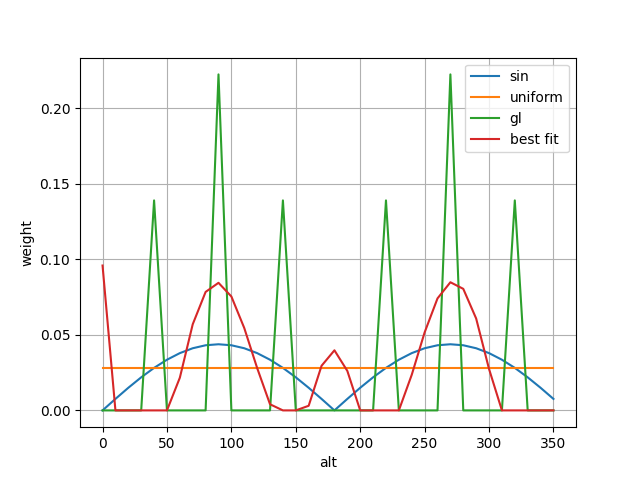

In [79]:
def plot_wgts(w, label=None, ax=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.plot(np.rad2deg(alt), w/jnp.sum(jnp.abs(w)), label=label)
    ax.set_xlabel("alt")
    ax.set_ylabel("weight")
    ax.grid(True)
    if label is not None:
        ax.legend()
    return ax


#ax = plot_wgts(wgts["zenith_sweep"], label="zenith sweep")
ax = plot_wgts(wgts["sin"], label="sin")
ax = plot_wgts(wgts["uniform"], label="uniform", ax=ax)
ax = plot_wgts(wgts["gl"], label="gl", ax=ax)
#ax = plot_wgts(wgts["lsq"], label="lsq")
ax = plot_wgts(wgts["best_fit"], label="best fit", ax=ax)

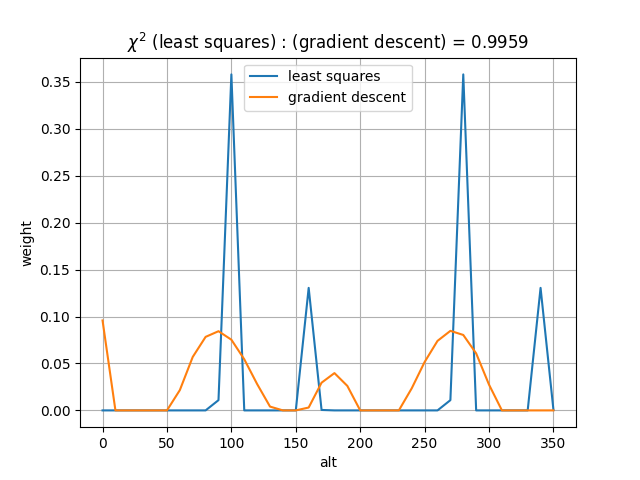

In [85]:
ax = plot_wgts(wgts["lsq"], label="least squares")
ax = plot_wgts(wgts["best_fit"], label="gradient descent", ax=ax)
ax.set_title(f"$\\chi^2$ (least squares) : (gradient descent) = {losses["lsq"] / losses["best_fit"]:.4f}")
plt.show()

Text(0.5, 1.0, '$\\chi^2$ (least squares) : (discrete) = 1.0000')

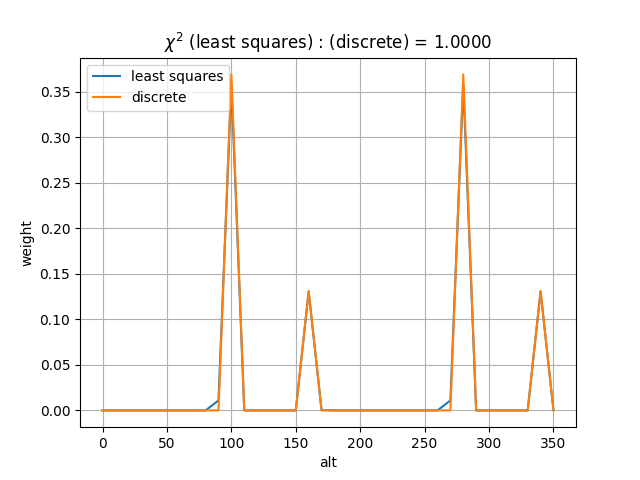

In [93]:
disw = wgts["lsq"].copy()
disw[16] = disw[16]+disw[17]
disw[17] = 0
disw[10] = disw[9]+disw[10]
disw[9] = 0
disw[28] = disw[27]+disw[28]
disw[27] = 0
disw[34] = disw[34]+disw[35]
disw[35] = 0
ax = plot_wgts(wgts["lsq"], label="least squares")
ax = plot_wgts(disw, label="discrete", ax=ax)
ax.set_title(f"$\\chi^2$ (least squares) : (discrete) = {losses["lsq"] / loss_fn(disw):.4f}")

In [96]:
print(np.rad2deg(alt[wgts["lsq"]>0]))
print(np.rad2deg(alt[disw>0]))

wgts["discrete_ls"] = disw
losses["discrete_ls"] = loss_fn(disw)

[ 90. 100. 160. 170. 270. 280. 340. 350.]
[100. 160. 280. 340.]


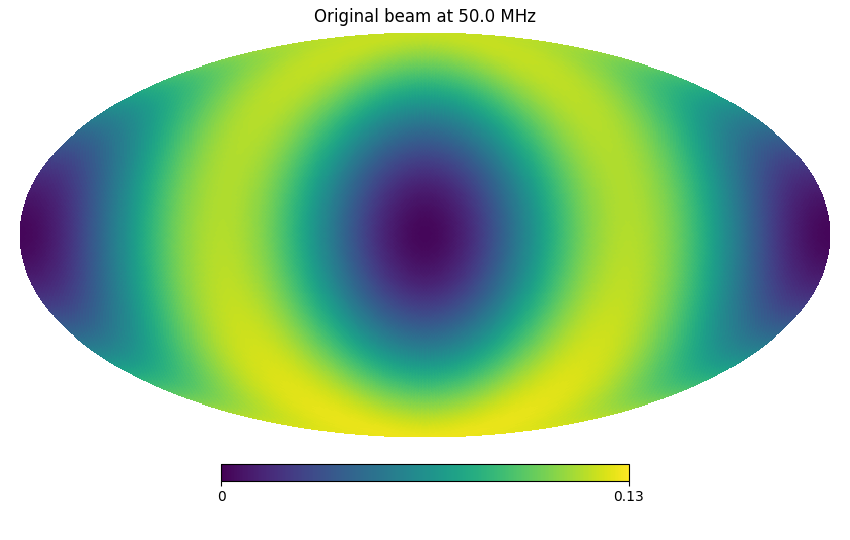

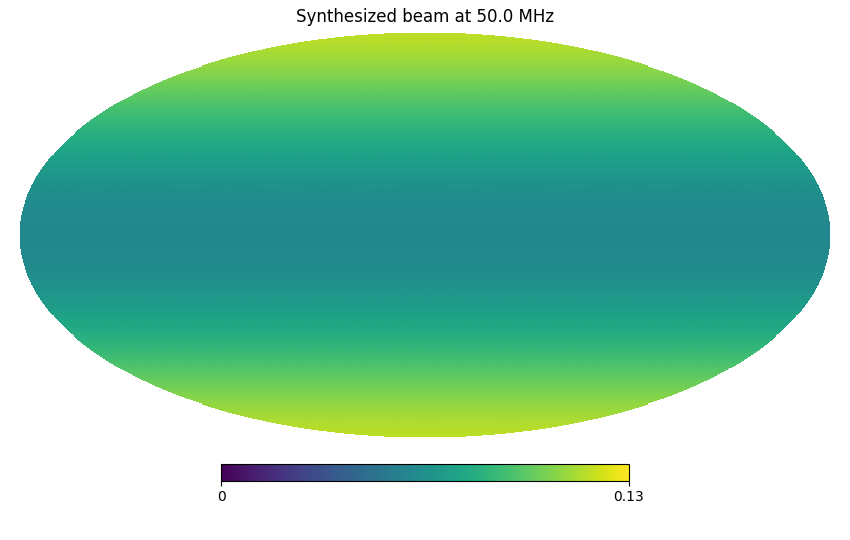

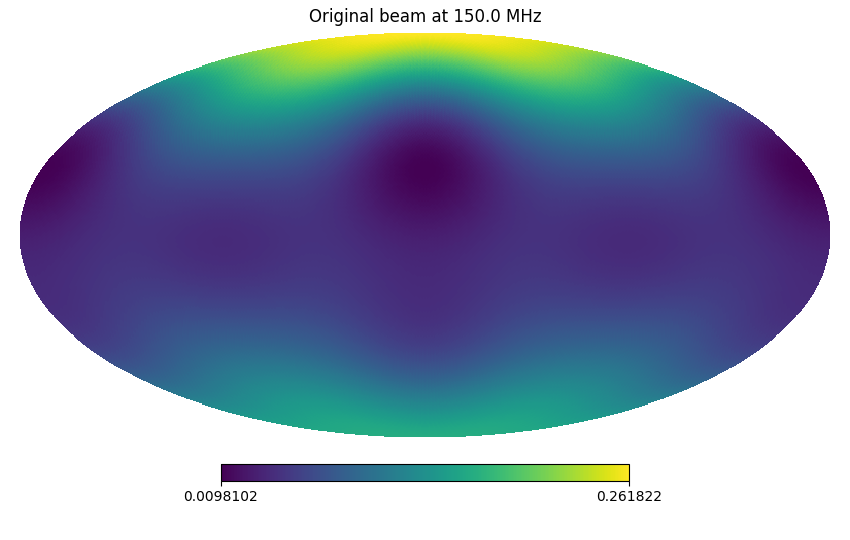

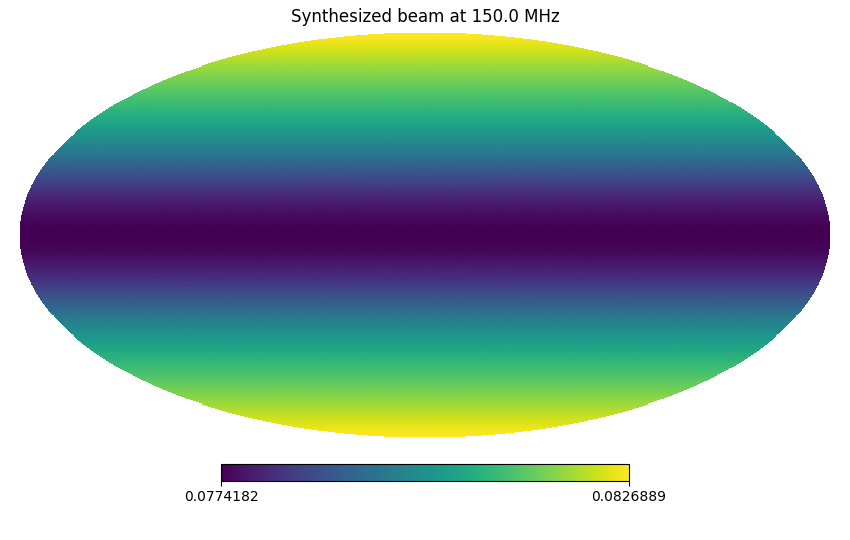

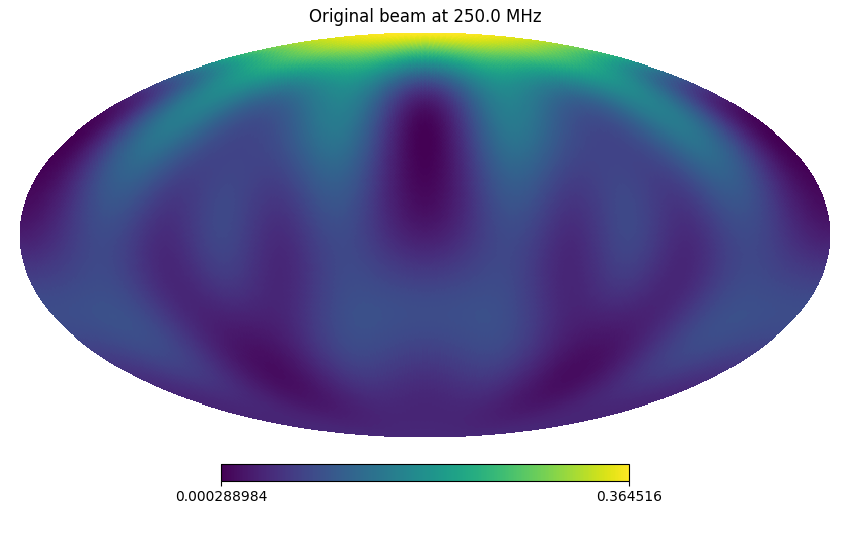

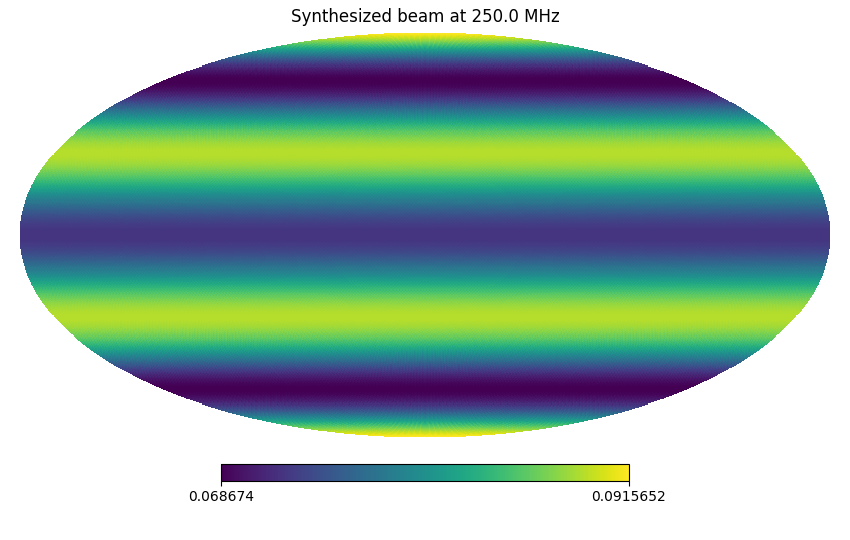

In [110]:
sbeams = {k: get_sbeam(v) for k, v in wgts.items()}

vmins = [0, None, None] 
vmaxs = [0.13, None, None] 

for i, ix in enumerate([0, 100, 200]):
    vmin = vmins[i]
    vmax = vmaxs[i]
    hp.mollview(beam[ix], title=f"Original beam at {freqs[ix]} MHz", min=vmin, max=vmax)
    hp.mollview(hp.alm2map(sbeams["discrete_ls"][ix], nside=nside), title=f"Synthesized beam at {freqs[ix]} MHz", min=vmin, max=vmax)

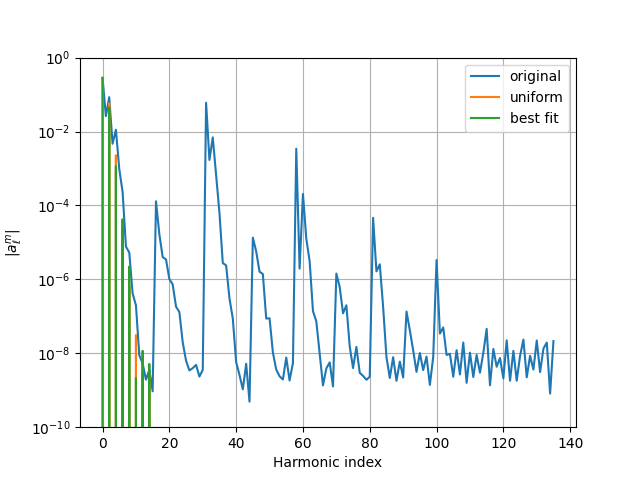

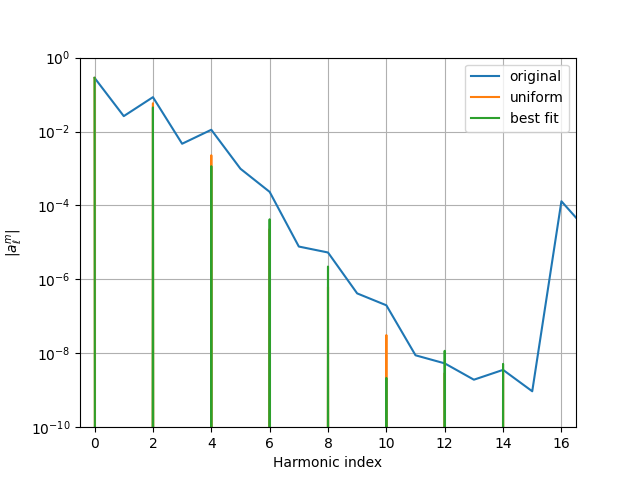

In [120]:
ix = 50

plt.figure()
plt.plot(np.abs(beam_alm[ix]), label="original")
for k, v in sbeams.items():
    if k not in ("original", "uniform", "discrete_ls"):
        continue
    if k == "discrete_ls":
        label = "best fit"
    else:
        label = k
    plt.plot(np.abs(v[ix]), label=label)
plt.xlabel("Harmonic index")
plt.ylabel("$|a_\\ell^m|$")
plt.grid()
plt.yscale("log")
plt.legend()
plt.ylim(1e-10, 1e0)
plt.show()

plt.figure()
plt.plot(np.abs(beam_alm[ix]), label="original")
for k, v in sbeams.items():
    if k not in ("original", "uniform", "discrete_ls"):
        continue
    if k == "discrete_ls":
        label = "best fit"
    else:
        label = k
    plt.plot(np.abs(v[ix]), label=label)
plt.xlabel("Harmonic index")
plt.ylabel("$|a_\\ell^m|$")
plt.grid()
plt.yscale("log")
plt.legend()
plt.ylim(1e-10, 1e0)
plt.xlim(-0.5, lmax+1.5)
plt.show()

In [170]:
sbeam = sbeams["discrete_ls"]

zeromodes = np.abs(sbeam) < 1e-5 * np.abs(sbeam[:, :1])
nonzeromodes = np.where(np.count_nonzero(zeromodes, axis=0) < len(sbeam))[0]  # the only modes that are sometimes nonzero
print(len(nonzeromodes))
print(nonzeromodes)

7
[ 0  2  4  6  8 10 12]


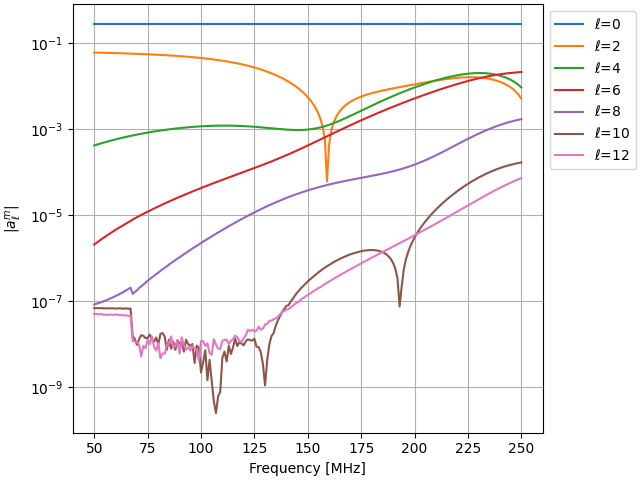

In [172]:
plt.figure(constrained_layout=True)
for i, nz in enumerate(nonzeromodes):
    ell, emm = hp.Alm.getlm(lmax, nz)
    plt.plot(freqs, np.abs(sbeam[:, nz]), label=f"$\\ell$={int(ell)}")
plt.legend(bbox_to_anchor=[1., 1.])
plt.yscale("log")
plt.grid()
plt.xlabel("Frequency [MHz]")
plt.ylabel("|$a_\\ell^m$|")
plt.show()

### Allow flexible azimuth weights

In [204]:
print(f"{beam_rot_alm.shape=} = (alt, az, freq, alm)")
print(f"{nfreq=}, {Nalm=}")

beam_rot_mat = beam_rot_alm.reshape(-1, nfreq, Nalm)
beam_rot_mat = np.moveaxis(beam_rot_mat, 0, 2)
print(f"{beam_rot_mat.shape=}")

beam_rot_alm.shape=(36, 36, 201, 136) = (alt, az, freq, alm)
nfreq=201, Nalm=np.int64(136)
beam_rot_mat.shape=(201, 136, 1296)


In [206]:
wgt_altaz = nnls(beam_rot_mat)
wgts_altaz = wgt_altaz.reshape(len(alt), len(az))

monopole.shape=(27336, 1)
beam_stack.shape=(27336, 1296)
monopole_reim.shape=(54672, 1)
beam_reim.shape=(54672, 1296)
expected shape, (1296, 1)
(1296,)


In [220]:
wgts_altaz

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.35911853e-03, 4.24956902e-03, 1.72333451e-03, ...,
        0.00000000e+00, 6.62341461e-03, 1.63573866e-03],
       [3.78685483e-06, 1.48350006e-05, 2.04113617e-05, ...,
        2.20303225e-05, 0.00000000e+00, 2.70484317e-05]], shape=(36, 36))

In [223]:
disw_aa = wgts_altaz.copy()
disw_aa[16] = disw_aa[16]+disw_aa[17]
disw_aa[17] = 0
disw_aa[10] = disw_aa[9]+disw_aa[10]
disw_aa[9] = 0
disw_aa[28] = disw_aa[27]+disw_aa[28]
disw_aa[27] = 0
disw_aa[34] = disw_aa[34]+disw_aa[35]
disw_aa[35] = 0

wgts["altaz"] = disw_aa

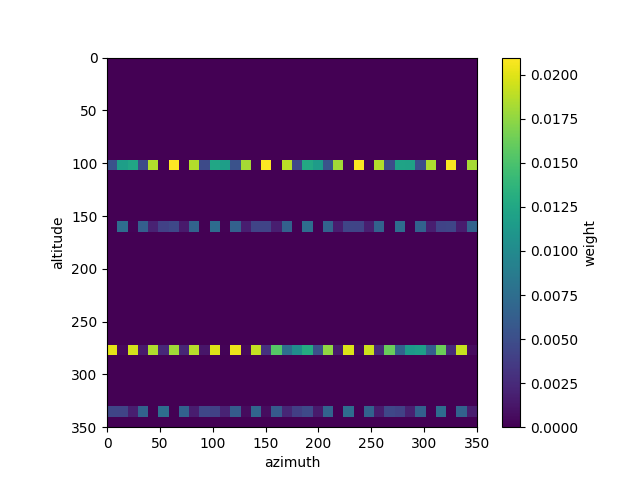

In [231]:
extent = [az[0], az[-1], alt[-1], alt[0]]
extent = np.rad2deg(extent)

plt.figure()
plt.imshow(wgts["altaz"], interpolation="none", extent=extent)
plt.colorbar(label="weight")
plt.xlabel("azimuth")
plt.ylabel("altitude")
plt.show()

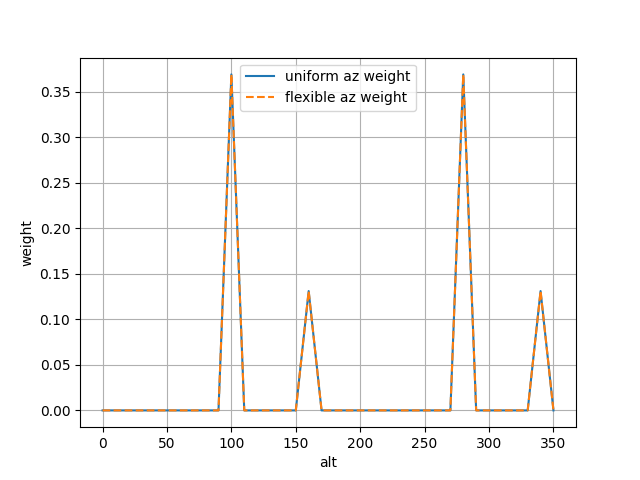

In [230]:
plt.figure()
plt.plot(np.rad2deg(alt), wgts["discrete_ls"], label="uniform az weight")
plt.plot(np.rad2deg(alt), wgts["altaz"].sum(axis=1), label="flexible az weight", ls="--")
plt.xlabel("alt")
plt.ylabel("weight")
plt.legend(loc="best")
plt.grid()
plt.show()

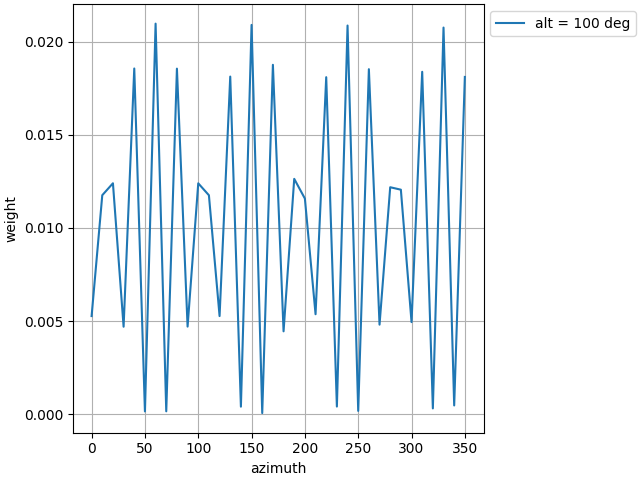

In [239]:
plt.figure(constrained_layout=True)
for i in np.nonzero(wgts["altaz"].sum(axis=1))[0]:
    plt.plot(np.rad2deg(az), wgts["altaz"][i], label=f"alt = {np.rad2deg(alt[i]):.0f} deg")
    break
plt.grid()
plt.xlabel("azimuth")
plt.ylabel("weight")
plt.legend(bbox_to_anchor=[1, 1])
plt.show()

In [247]:
sbeams["altaz"] = np.sum(beam_rot_alm * wgts["altaz"][:, :, None, None], axis=(0, 1)) / np.sum(wgts["altaz"])

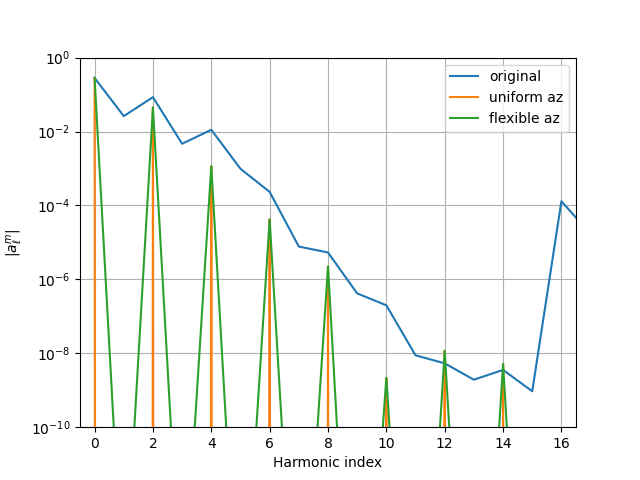

In [248]:
plt.figure()
plt.plot(np.abs(beam_alm[ix]), label="original")
for k, v in sbeams.items():
    if k not in ("original", "discrete_ls", "altaz"):
        continue
    if k == "discrete_ls":
        label = "uniform az"
    elif k == "altaz":
        label = "flexible az"
    else:
        label = k
    plt.plot(np.abs(v[ix]), label=label)
plt.xlabel("Harmonic index")
plt.ylabel("$|a_\\ell^m|$")
plt.grid()
plt.yscale("log")
plt.legend()
plt.ylim(1e-10, 1e0)
plt.xlim(-0.5, lmax+1.5)
plt.show()

In [255]:
monobeam = np.zeros_like(sbeams["altaz"])
monobeam[:, 0] = 1/np.sqrt(4*np.pi)

losses["altaz"] = np.mean(np.abs(sbeams["altaz"] - monobeam)**2)

print(losses["altaz"], losses["discrete_ls"])
print(losses["altaz"] / losses["discrete_ls"])

8.247266233963902e-06 8.247265e-06
1.0000001


In [256]:
np.allclose(sbeam, sbeams["altaz"])

True

In [259]:
np.savez("freespace.npz", freqs=freqs, lmax=lmax, nside=nside, alt=alt, az=az, bowtie_beam=beam_alm, wgts=wgts["discrete_ls"], synthesized_beam=sbeam)